<a href="https://colab.research.google.com/github/panjiang4/Coursera_Capstone/blob/main/Capstone_Safest_Neighborhood_in_Los_Angeles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera



```
# This is formatted as code
```

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

The aim of this project is to find a safe and secure location for opening of commercial establishments in Los Angeles, USA. Specifically, this report will be targeted to stakeholders interested in opening any business place like **Grocery Store** in **Los Angeles**, USA.

> Indented block



The first task would be to **choose the safest borough** by analysing crime data for opening a grocery store and **short listing a neighbourhood**, where grocery stores are not amongst the most commom venues, and yet **as close to the city as possible**.

We will make use of our data science tools to analyse data and focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood where grocery store is not amongst the most common venue can be selected.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* finding the safest borough based on crime statistics
* finding the most common venues
* choosing the right neighbourhood within the borough

We will be using the geographical coordinates of LA to plot neighbourhoods in a borough that is safe and in the city's vicinity, and finally cluster our neighborhoods and present our findings.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Using a real world data set from Kaggle containing the Los Angeles Crime & Arrest Data from 2010 to 2019](#part1):  A dataset consisting of the crime statistics of each neighborhood in LA along with type of crime, recorded year, month and hour.

- [**Part 2**: Gathering additional information of the list of officially categorized boroughs in LA from Wikipedia.](#part2): Borough information will be used to map the existing data where each neighbourhood can be assigned with the right borough.

- [**Part 3**: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data and the respective Neighborhood's co-ordinates.](#part3): This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

- [**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.](#part4): This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

###**Part 1:** Using a real world data set from Kaggle containing the Los Angeles Crimes from 2010 to 2019<a name="part1"></a>


####  LA Crime Report 

Main Properties of the Crime Report

*   DR Number
*   Date Reported
*   Date Occurred
*   Area Name
*   Crime Code Description
*   Address
*   Premise
*   Location

Data set URL: https://www.kaggle.com/cityofLA/los-angeles-crime-arrest-data?select=crime-data-from-2010-to-present.csv

Since the datasets are so huge >750MB, reduced version has been uploaded into GitHub with selected key columns with range 2014 to 2015
*   Date
*   Area
*   Crime
*   latitude--> it is sperated from Location
*   longitude -->it is seperated from Location 
*   Type--> crime type, aggregated type of Crime since there are more than 200 sbugroups

### Importing all the necessary Libraries

In [ ]:

import numpy as np
import pandas as pd

#Command to install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

print('Libraries imported')

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 2.6MB 12.4MB/s 
Matplotlib version:  3.2.2
Libraries imported


###Reading from the Dataset
around 250000 rows

In [ ]:
la_crime_df = pd.read_csv('https://raw.githubusercontent.com/panjiang4/Coursera_Capstone/main/crime-data-from-2010-to-present.csv', index_col=None)

#Dropping X,Y which represents Lat, Lng data as Coordinates, the data seems to be corrupt
#la_crime_df.drop(['Unnamed: 0','MINUTE', 'HUNDRED_BLOCK', 'X', 'Y'], axis = 1, inplace = True)

#vnc_crime_df.columns

la_crime_df.head()

,Date,Area,Crime,latitude,longitude,Type
0,1/4/2014,Topanga,VANDALISM - MISDEAMEANOR ($399 OR UNDER),34.2009,-118.6369,VANDALISM
1,4/25/2014,Wilshire,BATTERY - SIMPLE ASSAULT,34.0361,-118.3392,ASSAULT
2,1/1/2014,West LA,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",34.0662,-118.4507,ASSAULT
3,10/31/2014,Van Nuys,CRUELTY TO ANIMALS,34.1685,-118.4662,CRUELTY TO ANIMALS
4,11/1/2014,Central,VEHICLE - STOLEN,34.0446,-118.2490,THEFT


###Total Crimes in different Neighborhoods

In [ ]:
la_crime_df['Area'].value_counts()

Southwest      26336
Central        18396
Rampart        17530
Harbor         17506
Hollenbeck     14662
77th Street    14031
Pacific        10737
Southeast      10538
N Hollywood    10371
Hollywood      10030
Mission         9904
Northeast       9673
Van Nuys        9425
Newton          9194
Olympic         9133
Topanga         8755
Devonshire      8621
West LA         8174
Wilshire        7906
West Valley     7900
Foothill        7112
Name: Area, dtype: int64

#####Further Cleaning the data by dropping rows with invalid data

In [ ]:
la_crime_df.dropna(inplace=True)
la_crime_df['Area'].value_counts()

Southwest      26336
Central        18396
Rampart        17530
Harbor         17506
Hollenbeck     14662
77th Street    14031
Pacific        10737
Southeast      10538
N Hollywood    10371
Hollywood      10030
Mission         9904
Northeast       9673
Van Nuys        9425
Newton          9194
Olympic         9133
Topanga         8755
Devonshire      8621
West LA         8174
Wilshire        7906
West Valley     7900
Foothill        7112
Name: Area, dtype: int64

##Methodology<a name="methodology"></a>

Categorized the methodologysection into two parts:

- [**Exploratory Data Analysis**:](#eda) Visualise the crime repots in different Los Angeles boroughs to idenity the safest borough and normalise the neighborhoods of that borough. We will Use the resulting data and find 10 most common venues in each neighborhood.


- [**Modelling**:](#mdl) To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use K-Means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.

####Exploratory Data Analysis<a name="eda"></a>

####Pivoting the table to better understand the data by crimes per Area

In [ ]:
la_crime_cat = pd.pivot_table(la_crime_df,
                               values=['Date'],
                               index=['Area'],
                               columns=['Crime'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
la_crime_cat

Date  ...        
Crime       ARSON  ...     All
Area               ...        
77th Street    28  ...   14031
Central        37  ...   18396
Devonshire      8  ...    8621
Foothill       17  ...    7112
Harbor         38  ...   17506
Hollenbeck     39  ...   14662
Hollywood      13  ...   10030
Mission        16  ...    9904
N Hollywood     9  ...   10371
Newton         18  ...    9194
Northeast      19  ...    9673
Olympic         9  ...    9133
Pacific         7  ...   10737
Rampart        25  ...   17530
Southeast      36  ...   10538
Southwest      38  ...   26336
Topanga         6  ...    8755
Van Nuys       10  ...    9425
West LA         7  ...    8174
West Valley     7  ...    7900
Wilshire        5  ...    7906
All           392  ...  245934

[22 rows x 132 columns]

#####Crime is too details, let us use Crime Type instead

> Indented block



In [ ]:
la_crime_cat = pd.pivot_table(la_crime_df,
                               values=['Date'],
                               index=['Area'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
la_crime_cat

Date                            ...                                   
Type        ARSON ASSAULT BIGAMY BOMB SCARE  ... VANDALISM VIOLATION WEAPON     All
Area                                         ...                                   
77th Street    28    4088      0          5  ...      1448       388    154   14031
Central        37    5578      0         30  ...      1513       139    157   18396
Devonshire      8    1494      0          2  ...       732       207     47    8621
Foothill       17    1453      0          3  ...       745       170     48    7112
Harbor         38    3542      0          7  ...      1891       650    178   17506
Hollenbeck     39    3706      0          3  ...      1544       386    202   14662
Hollywood      13    2383      0          7  ...      1027       116     80   10030
Mission        16    2033      0          1  ...       964       299     53    9904
N Hollywood     9    1819      0          4  ...      1077       224     47   10371
Newton         18    2395      0          2  ...       854       147     82    9194
Northeast      19    1770      0          4  ...      1122       263     41    9673
Olympic         9    2462      1          4  ...       861       112     53    9133
Pacific         7    1521      0         12  ...      1026       150     40   10737
Rampart        25    4914      0         11  ...      1672       303    181   17530
Southeast      36    3142      0          0  ...      1023       250    139   10538
Southwest      38    6551      0         10  ...      2323       478    270   26336
Topanga         6    1581      0          2  ...       766       192     29    8755
Van Nuys       10    1953      0          1  ...       909       284     56    9425
West LA         7    1217      0          4  ...       739       109     33    8174
West Valley     7    1437      2          5  ...       712       228     42    7900
Wilshire        5    1366      0          6  ...       703       130     38    7906
All           392   56405      3        123  ...     23651      5225   1970  245934

[22 rows x 31 columns]

In [ ]:
la_crime_cat.reset_index(inplace = True)
la_crime_cat.columns = la_crime_cat.columns.map(''.join)
la_crime_cat.rename(columns={'DateAll':'Total'}, inplace=True)
la_crime_cat

,Area,DateARSON,DateASSAULT,DateBIGAMY,DateBOMB SCARE,DateBRIBERY,DateBUNCO,DateBURGLARY,DateCHILD RELATED,DateCONSPIRACY,DateCONTEMPT OF COURT,DateCONTRIBUTING,DateCOUNTERFEIT,DateCRIMINAL HOMICIDE,DateCRUELTY TO ANIMALS,DateDISHONEST,DateDISRUPT,DateDRIVING,DateDRUGS,DateDRUNK,DateFRAUD,DateKIDNAPPING,DateLYNCHING,DateOTHER MISCELLANEOUS CRIME,DateRAPE,DateROBBERY,DateTHEFT,DateTHREATS,DateVANDALISM,DateVIOLATION,DateWEAPON,Total
0,77th Street,28,4088,0,5,0,121,1739,290,0,1,0,3,50,9,0,6,2,0,0,3,30,0,395,85,1015,3692,479,1448,388,154,14031
1,Central,37,5578,0,30,1,110,1711,51,1,8,0,7,17,4,3,47,6,0,1,61,25,2,651,166,1159,6354,557,1513,139,157,18396
2,Devonshire,8,1494,0,2,0,112,1462,102,0,3,2,8,2,3,3,27,0,1,0,17,6,0,276,39,138,3734,196,732,207,47,8621
3,Foothill,17,1453,0,3,0,68,866,157,1,4,1,0,14,3,0,3,1,3,0,9,14,1,253,52,190,2775,261,745,170,48,7112
4,Harbor,38,3542,0,7,0,110,2695,303,0,21,1,3,15,7,3,7,5,0,0,23,23,2,430,75,540,6559,378,1891,650,178,17506
5,Hollenbeck,39,3706,0,3,0,90,1542,263,0,66,1,0,28,10,2,8,4,0,0,10,25,0,391,79,577,5255,431,1544,386,202,14662
6,Hollywood,13,2383,0,7,0,45,1463,64,0,1,0,8,9,3,1,11,1,0,0,27,11,2,414,125,450,3559,210,1027,116,80,10030
7,Mission,16,2033,0,1,0,65,1326,284,1,0,2,3,14,7,1,12,4,1,0,20,10,0,362,46,292,3741,347,964,299,53,9904
8,N Hollywood,9,1819,0,4,0,83,1776,126,0,2,1,7,7,6,2,22,0,0,0,22,14,0,357,43,185,4249,289,1077,224,47,10371
9,Newton,18,2395,0,2,0,49,1173,170,0,3,1,4,16,7,2,7,1,0,0,3,11,0,246,50,627,2883,443,854,147,82,9194


#####Pandas describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values.

In [ ]:
la_crime_cat.describe()

,DateARSON,DateASSAULT,DateBIGAMY,DateBOMB SCARE,DateBRIBERY,DateBUNCO,DateBURGLARY,DateCHILD RELATED,DateCONSPIRACY,DateCONTEMPT OF COURT,DateCONTRIBUTING,DateCOUNTERFEIT,DateCRIMINAL HOMICIDE,DateCRUELTY TO ANIMALS,DateDISHONEST,DateDISRUPT,DateDRIVING,DateDRUGS,DateDRUNK,DateFRAUD,DateKIDNAPPING,DateLYNCHING,DateOTHER MISCELLANEOUS CRIME,DateRAPE,DateROBBERY,DateTHEFT,DateTHREATS,DateVANDALISM,DateVIOLATION,DateWEAPON,Total
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,35.636364,5127.727273,0.272727,11.181818,0.090909,153.818182,3159.909091,319.090909,0.545455,13.818182,1.272727,8.454545,29.727273,14.545455,3.181818,33.454545,5.000000,0.545455,0.272727,37.818182,31.181818,0.727273,726.545455,132.181818,979.727273,8045.454545,681.272727,2150.090909,475.000000,179.090909,22357.636364
std,80.516514,11548.118128,0.767297,25.749039,0.294245,344.828271,7076.476954,718.762820,1.299350,34.135077,2.930656,19.088085,67.889393,32.717736,7.215304,75.474832,11.430952,1.405000,0.767297,85.601311,70.378322,1.777688,1628.481376,297.685138,2223.556550,18038.078175,1531.810668,4821.714987,1069.265836,405.799377,50152.305600
min,5.000000,1217.000000,0.000000,0.000000,0.000000,4.000000,866.000000,36.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,246.000000,37.000000,128.000000,2752.000000,166.000000,703.000000,109.000000,29.000000,7112.000000
25%,8.250000,1536.000000,0.000000,2.250000,0.000000,70.250000,1390.000000,106.000000,0.000000,0.250000,0.000000,3.000000,7.000000,6.000000,1.000000,8.750000,1.000000,0.000000,0.000000,9.250000,9.250000,0.000000,295.000000,41.500000,204.500000,3146.250000,240.250000,788.000000,147.750000,43.250000,8849.500000
50%,16.500000,2208.000000,0.000000,4.000000,0.000000,91.000000,1512.000000,141.000000,0.000000,2.000000,1.000000,4.500000,12.000000,7.000000,1.500000,17.000000,2.000000,0.000000,0.000000,20.000000,12.000000,0.000000,356.500000,52.000000,375.000000,3715.000000,320.000000,1024.500000,226.000000,54.500000,9967.000000
75%,34.000000,3665.000000,0.000000,7.000000,0.000000,100.250000,1766.750000,267.500000,1.000000,7.000000,1.000000,7.000000,23.000000,10.000000,3.000000,23.750000,4.000000,0.000000,0.000000,24.750000,25.000000,0.750000,409.250000,83.500000,738.000000,5115.000000,440.000000,1496.750000,302.000000,156.250000,14504.250000
max,392.000000,56405.000000,3.000000,123.000000,1.000000,1692.000000,34759.000000,3510.000000,6.000000,152.000000,14.000000,93.000000,327.000000,160.000000,35.000000,368.000000,55.000000,6.000000,3.000000,416.000000,343.000000,8.000000,7992.000000,1454.000000,10777.000000,88500.000000,7494.000000,23651.000000,5225.000000,1970.000000,245934.000000


**bold text**####Expolring the data by Visualising

#####Sorting the data by crimes per neighborhood

In [ ]:
la_crime_cat.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

crime_neigh_top5 = la_crime_cat.iloc[1:6]
crime_neigh_top5

,Area,DateARSON,DateASSAULT,DateBIGAMY,DateBOMB SCARE,DateBRIBERY,DateBUNCO,DateBURGLARY,DateCHILD RELATED,DateCONSPIRACY,DateCONTEMPT OF COURT,DateCONTRIBUTING,DateCOUNTERFEIT,DateCRIMINAL HOMICIDE,DateCRUELTY TO ANIMALS,DateDISHONEST,DateDISRUPT,DateDRIVING,DateDRUGS,DateDRUNK,DateFRAUD,DateKIDNAPPING,DateLYNCHING,DateOTHER MISCELLANEOUS CRIME,DateRAPE,DateROBBERY,DateTHEFT,DateTHREATS,DateVANDALISM,DateVIOLATION,DateWEAPON,Total
15,Southwest,38,6551,0,10,0,101,3223,373,0,17,0,8,46,18,1,23,4,0,0,24,43,0,811,153,1558,9315,948,2323,478,270,26336
1,Central,37,5578,0,30,1,110,1711,51,1,8,0,7,17,4,3,47,6,0,1,61,25,2,651,166,1159,6354,557,1513,139,157,18396
13,Rampart,25,4914,0,11,0,82,2290,269,1,19,2,3,25,8,3,14,7,1,2,18,32,0,566,117,1160,5195,610,1672,303,181,17530
4,Harbor,38,3542,0,7,0,110,2695,303,0,21,1,3,15,7,3,7,5,0,0,23,23,2,430,75,540,6559,378,1891,650,178,17506
5,Hollenbeck,39,3706,0,3,0,90,1542,263,0,66,1,0,28,10,2,8,4,0,0,10,25,0,391,79,577,5255,431,1544,386,202,14662


#####Five Neighborhoods with highest crime

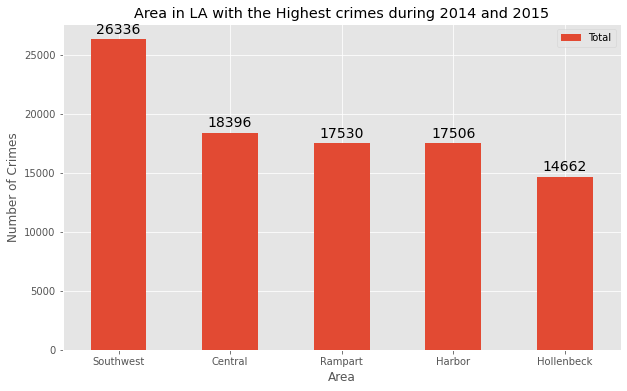

In [ ]:
per_neigh = crime_neigh_top5[['Area','Total']]

per_neigh.set_index('Area',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Area')
ax.set_title('Area in LA with the Highest crimes during 2014 and 2015')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#####Five Neighborhoods with lowest crime

In [ ]:
crime_neigh_low = la_crime_cat.tail(5)
crime_neigh_low

,Area,DateARSON,DateASSAULT,DateBIGAMY,DateBOMB SCARE,DateBRIBERY,DateBUNCO,DateBURGLARY,DateCHILD RELATED,DateCONSPIRACY,DateCONTEMPT OF COURT,DateCONTRIBUTING,DateCOUNTERFEIT,DateCRIMINAL HOMICIDE,DateCRUELTY TO ANIMALS,DateDISHONEST,DateDISRUPT,DateDRIVING,DateDRUGS,DateDRUNK,DateFRAUD,DateKIDNAPPING,DateLYNCHING,DateOTHER MISCELLANEOUS CRIME,DateRAPE,DateROBBERY,DateTHEFT,DateTHREATS,DateVANDALISM,DateVIOLATION,DateWEAPON,Total
2,Devonshire,8,1494,0,2,0,112,1462,102,0,3,2,8,2,3,3,27,0,1,0,17,6,0,276,39,138,3734,196,732,207,47,8621
18,West LA,7,1217,0,4,0,83,1695,36,0,0,0,0,4,1,1,24,2,0,0,12,3,0,356,38,128,3516,166,739,109,33,8174
20,Wilshire,5,1366,0,6,0,94,1520,120,0,0,0,7,8,8,2,14,3,0,0,21,13,0,270,37,297,3023,221,703,130,38,7906
19,West Valley,7,1437,2,5,0,92,1393,104,0,3,0,0,4,7,1,23,0,0,0,9,9,0,330,41,201,3022,228,712,228,42,7900
3,Foothill,17,1453,0,3,0,68,866,157,1,4,1,0,14,3,0,3,1,3,0,9,14,1,253,52,190,2775,261,745,170,48,7112


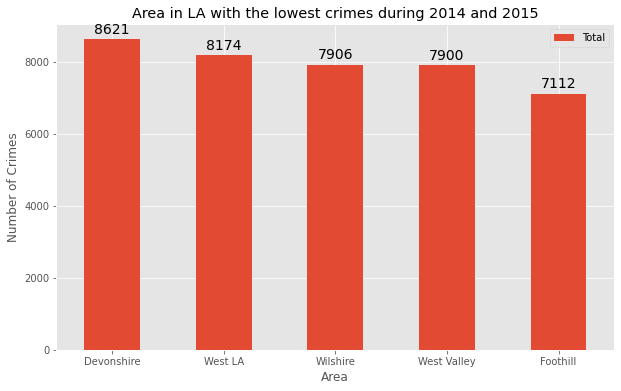

In [ ]:
per_neigh = crime_neigh_low[['Area','Total']]

per_neigh.set_index('Area',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Area')
ax.set_title('Area in LA with the lowest crimes during 2014 and 2015')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

### Based on exploratory data analysis it is clear that Foothill has the lowest crimes

##### Since Foothill has very little number of neighborhoods (highway and less populations) and opening a commercial establishment would not be viable, we can choose the next borough with lowest crime which is **West Valley**.

####Different types of crimes recorded in the West Valley Area

####West Valley was chosen because crime type Weapon, Theft and Robbery is also low amongst other crimes types which makes West Valley ideal destination for opening of commercial establishments

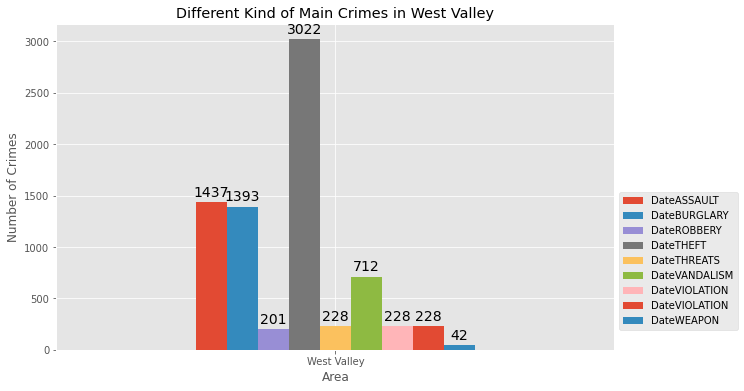

In [ ]:
 la_wv_df = la_crime_cat[la_crime_cat['Area'] == 'West Valley']

 la_wv_df =  la_wv_df.sort_values(['Total'], ascending = True, axis = 0)

 la_wv = la_wv_df[['Area','DateASSAULT', 'DateBURGLARY','DateROBBERY','DateTHEFT','DateTHREATS',
                 'DateVANDALISM','DateVIOLATION','DateVIOLATION',
                 'DateWEAPON']]


la_wv.set_index('Area',inplace = True)

ax = la_wv.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Area')
ax.set_title('Different Kind of Main Crimes in West Valley')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=3), 
                (p.get_x()+p.get_width()/3., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(5, 10), 
                textcoords='offset points',
                fontsize = 14
               )
    ax.legend(loc='upper left', bbox_to_anchor=(1.00, 0.5))

plt.show()

###**Part 3**: Creating a new consolidated dataset of the areas, crime data and the respective Neighbourhood's co-ordinates.<a name="part3"></a>: 

####This data will be fetched using OpenCage Geocoder to find the safest area and explore the neighbourhood by plotting it on maps using Folium and perform exploratory data analysis.

#####Restricting the rows in the data frame to only those with West Valley as Area

In [ ]:
la_wf = la_crime_df
la_wf = la_wf[la_wf['Area'] == 'West Valley']
la_wf.drop(['Date','Area', 'Type','Crime'], axis = 1, inplace = True)
#to remove duplicated cases on the same location
la_wf = pd.DataFrame(np.unique(la_wf[['latitude', 'longitude']], axis=0), columns=['latitude', 'longitude'])
la_wf.drop(la_wf.index[:1], inplace=True)
print('Number of Neighbourhoods to be ploted in West Valley', len(la_wf))

#vnc_ws_neigh['Neighbourhood'].unique()

Number of Neighbourhoods to be ploted in West Valley 2071


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#####Creating a new Data frame with Lat, Lng being fetched from OpenCage geocoder

In [ ]:
Latitude = []
Longitude = []
Borough = []
#Neighbourhood = vnc_ws_neigh['Neighbourhood'].unique()

key = '830323b5ca694362904814ff0a11b803'
geocoder = OpenCageGeocode(key)

for i in range(1,len(la_wf)+1):
    #address = '{}, Vancouver, BC, Canada'.format(Neighbourhood[i])
    #location = geocoder.geocode(address)
    Latitude.append(la_wf['latitude'][i])
    Longitude.append(la_wf['longitude'][i])
    Borough.append('West Walley')
print(Latitude, Longitude)

[34.0908, 34.0976, 34.1294, 34.1298, 34.1318, 34.1318, 34.1319, 34.1319, 34.1322, 34.1322, 34.1324, 34.1326, 34.1328, 34.1329, 34.1332, 34.1335, 34.1336, 34.1338, 34.1341, 34.1341, 34.1342, 34.1348, 34.1348, 34.1349, 34.1353, 34.1354, 34.1355, 34.1355, 34.1359, 34.135999999999996, 34.135999999999996, 34.1361, 34.1362, 34.1363, 34.1365, 34.1365, 34.1365, 34.1365, 34.1365, 34.1367, 34.1368, 34.1369, 34.137, 34.1372, 34.1374, 34.1377, 34.1377, 34.1377, 34.138000000000005, 34.138000000000005, 34.138000000000005, 34.1381, 34.1384, 34.1384, 34.1386, 34.139, 34.1393, 34.1394, 34.1396, 34.1396, 34.1397, 34.1398, 34.1398, 34.1398, 34.1398, 34.1399, 34.1401, 34.1403, 34.1404, 34.1408, 34.1409, 34.141, 34.1411, 34.1413, 34.1413, 34.1414, 34.1415, 34.1415, 34.1415, 34.1416, 34.1418, 34.1418, 34.1419, 34.1422, 34.1422, 34.1424, 34.1427, 34.1429, 34.1431, 34.1431, 34.1434, 34.1434, 34.1437, 34.1437, 34.1437, 34.1439, 34.1441, 34.1441, 34.1443, 34.1443, 34.1443, 34.1445, 34.1445, 34.1446, 34.1446, 34

####Glimpse of the new Data Frame with Neighborhoods in West Valley along with centroid of their co-ordinates

In [ ]:
wv_neig_dict = {'Neighbourhood':Borough,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
wv_neig_geo = pd.DataFrame(data=wv_neig_dict, columns=['Neighbourhood','Borough', 'Latitude', 'Longitude'], index=None)

wv_neig_geo

,Neighbourhood,Borough,Latitude,Longitude
0,West Walley,West Walley,34.0908,-118.3064
1,West Walley,West Walley,34.0976,-118.3674
2,West Walley,West Walley,34.1294,-118.5023
3,West Walley,West Walley,34.1298,-118.4805
4,West Walley,West Walley,34.1318,-118.4958
...,...,...,...,...
2066,West Walley,West Walley,34.2214,-118.4837
2067,West Walley,West Walley,34.2214,-118.4746
2068,West Walley,West Walley,34.2214,-118.4732
2069,West Walley,West Walley,34.2214,-118.4731


####Fetching the Geographical co-ordiantes of Los Angeles to plot on Map

In [ ]:
address = 'Los Angeles, CA, USA'

location = geocoder.geocode(address)
latitude = location[0]['geometry']['lat']
longitude = location[0]['geometry']['lng']

print('The geograpical coordinate of LA, USA are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of LA, USA are 34.0536909, -118.242766.


####Using Folium to plot Los Angeles's West Valley Area and it's Neighborhoods

In [ ]:
van_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(wv_neig_geo['Latitude'], wv_neig_geo['Longitude'], wv_neig_geo['Borough'], wv_neig_geo['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(van_map)  
    
van_map

###**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.<a name="part4"></a>: 
#####This data will be fetched using Four Square API to explore the neighbourhood venues and to apply machine learning algorithm to cluster the neighbourhoods and present the findings by plotting it on maps using Folium.

####Setting Up Foursquare Credentials

In [ ]:
#Four Square Credentials

CLIENT_ID = 'BCLVYAKGNFTQTTX52IBVEPQ5MQOIN33XLZVU05HJZ0XVBXRY'
CLIENT_SECRET = 'TAMBAJNS2TVYPXF50S3WBH1F4MYADVD5RO0BE3KWSNAKPX5T'
VERSION = '20180605'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BCLVYAKGNFTQTTX52IBVEPQ5MQOIN33XLZVU05HJZ0XVBXRY
CLIENT_SECRET:TAMBAJNS2TVYPXF50S3WBH1F4MYADVD5RO0BE3KWSNAKPX5T


####Defining a function to fetch top 10 venues around a given neighborhood

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

####Generating Venues

In [ ]:
wv_neig_geo=wv_neig_geo.sample(25) 
wv_neig_geo['Number']= range(1, 26 ,1)
wv_neig_geo['Neighbourhood']=wv_neig_geo['Borough']+wv_neig_geo['Number'].astype(str) 
print(wv_neig_geo)

      Neighbourhood      Borough  Latitude  Longitude  Number
1989   West Walley1  West Walley   34.2182  -118.4749       1
1921   West Walley2  West Walley   34.2157  -118.5220       2
1458   West Walley3  West Walley   34.2012  -118.4859       3
291    West Walley4  West Walley   34.1574  -118.5300       4
236    West Walley5  West Walley   34.1543  -118.4691       5
1741   West Walley6  West Walley   34.2094  -118.5405       6
1183   West Walley7  West Walley   34.1939  -118.5230       7
121    West Walley8  West Walley   34.1461  -118.5501       8
1785   West Walley9  West Walley   34.2107  -118.5300       9
348   West Walley10  West Walley   34.1595  -118.5045      10
1605  West Walley11  West Walley   34.2049  -118.4761      11
620   West Walley12  West Walley   34.1723  -118.5447      12
2043  West Walley13  West Walley   34.2205  -118.5514      13
391   West Walley14  West Walley   34.1611  -118.5406      14
1305  West Walley15  West Walley   34.1975  -118.5535      15
1985  We

In [ ]:
wv_venues = getNearbyVenues(names=wv_neig_geo['Neighbourhood'],
                                   latitudes=wv_neig_geo['Latitude'],
                                   longitudes=wv_neig_geo['Longitude']
                            )

West Walley1
West Walley2
West Walley3
West Walley4
West Walley5
West Walley6
West Walley7
West Walley8
West Walley9
West Walley10
West Walley11
West Walley12
West Walley13
West Walley14
West Walley15
West Walley16
West Walley17
West Walley18
West Walley19
West Walley20
West Walley21
West Walley22
West Walley23
West Walley24
West Walley25


####Data frame containing venues for each neighborhood in West Walley

In [ ]:
print(wv_venues.shape)
wv_venues.head()

(352, 5)


,Neighbourhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Category
0,West Walley1,34.2182,-118.4749,Original Tommy's Hamburgers,Burger Joint
1,West Walley1,34.2182,-118.4749,Restaurant Depot,Kitchen Supply Store
2,West Walley1,34.2182,-118.4749,Galpin Auto Sports (GAS),Automotive Shop
3,West Walley1,34.2182,-118.4749,Denny's,Breakfast Spot
4,West Walley1,34.2182,-118.4749,SUBWAY,Sandwich Place


###Modelling<a name="mdl"></a>

#####One Hot Encoding to Analyze Each Neighborhood

In [ ]:
# one hot encoding
wv_onehot = pd.get_dummies(wv_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
wv_onehot['Neighbourhood'] = wv_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [wv_onehot.columns[-1]] + list(wv_onehot.columns[:-1])
wv_onehot = wv_onehot[fixed_columns]

wv_onehot.head()

,Neighbourhood,ATM,Airport,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bank,Board Shop,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Campground,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Diner,Discount Store,Dive Bar,...,Non-Profit,Office,Optical Shop,Outdoor Supply Store,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Pool,Print Shop,Record Shop,Recording Studio,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Sorority House,Spa,Speakeasy,Sporting Goods Shop,State / Provincial Park,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Shop,Wings Joint,Yoga Studio
0,West Walley1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,West Walley1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,West Walley1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,West Walley1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,West Walley1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
wv_onehot.shape

(352, 136)

In [ ]:
wv_grouped = wv_onehot.groupby('Neighbourhood').mean().reset_index()
wv_grouped

,Neighbourhood,ATM,Airport,Airport Lounge,Airport Terminal,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bakery,Bank,Board Shop,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Café,Cajun / Creole Restaurant,Campground,Candy Store,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Construction & Landscaping,Convenience Store,Cosmetics Shop,Dance Studio,Deli / Bodega,Department Store,Diner,Discount Store,Dive Bar,...,Non-Profit,Office,Optical Shop,Outdoor Supply Store,Park,Pet Service,Pet Store,Pharmacy,Pizza Place,Pool,Print Shop,Record Shop,Recording Studio,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Sorority House,Spa,Speakeasy,Sporting Goods Shop,State / Provincial Park,Steakhouse,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Tex-Mex Restaurant,Thai Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Wine Shop,Wings Joint,Yoga Studio
0,West Walley1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.086957,0.043478,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.086957,0.043478,0.000000,0.000000,0.043478,0.000000,0.000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000,0.043478,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000,0.000000,0.000000
1,West Walley10,0.046512,0.000000,0.000000,0.000000,0.023256,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.023256,0.046512,0.023256,0.000000,0.000,0.023256,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.069767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.023256,0.000000,0.023256,0.000000,0.046512,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.046512,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.023256,0.000000,0.0,0.046512,0.000000,0.000000,0.023256,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.069767
2,West Walley11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000,0.000000,0.000000
3,West Walley12,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.050000,0.000000,0.000000,0.025,0.075000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.025,0.0,0.000000,0.000000,...,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.000000,0.025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.0,0.075000,0.000000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.025,0.000000,0.000000
4,West Walley13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,0.000000,0.000000,0.

In [ ]:
wv_grouped.shape

(23, 136)

####Top 5 most common venues across neighborhoods

In [ ]:
num_top_venues = 5

for hood in wv_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = wv_grouped[wv_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----West Walley1----
                  venue  freq
0           Coffee Shop  0.09
1  Fast Food Restaurant  0.09
2            Food Truck  0.09
3        Breakfast Spot  0.09
4            Print Shop  0.04


----West Walley10----
                venue  freq
0         Yoga Studio  0.07
1  Chinese Restaurant  0.07
2                Bank  0.05
3    Sushi Restaurant  0.05
4      Sandwich Place  0.05


----West Walley11----
                  venue  freq
0          Intersection  0.17
1       Warehouse Store  0.17
2                  Pool  0.17
3  Fast Food Restaurant  0.17
4  Gym / Fitness Center  0.17


----West Walley12----
                      venue  freq
0               Pizza Place  0.08
1          Sushi Restaurant  0.08
2            Breakfast Spot  0.08
3       Japanese Restaurant  0.08
4  Mediterranean Restaurant  0.05


----West Walley13----
                       venue  freq
0       Fast Food Restaurant  0.12
1         Mexican Restaurant  0.12
2                Pizza Place  0.06
3          

####Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = wv_grouped['Neighbourhood']

for ind in np.arange(wv_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(wv_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,West Walley1,Coffee Shop,Fast Food Restaurant,Food Truck,Breakfast Spot,Construction & Landscaping,Kitchen Supply Store,Dance Studio,Mexican Restaurant,Print Shop,Recording Studio
1,West Walley10,Yoga Studio,Chinese Restaurant,Sushi Restaurant,Bank,Frozen Yogurt Shop,Grocery Store,Pizza Place,Sandwich Place,ATM,Hookah Bar
2,West Walley11,Intersection,Warehouse Store,Spa,Pool,Gym / Fitness Center,Fast Food Restaurant,Yoga Studio,Electronics Store,Food Truck,Food & Drink Shop
3,West Walley12,Pizza Place,Sushi Restaurant,Breakfast Spot,Japanese Restaurant,Mediterranean Restaurant,Bank,American Restaurant,Thai Restaurant,Chinese Restaurant,Locksmith
4,West Walley13,Mexican Restaurant,Fast Food Restaurant,Market,Athletics & Sports,Pool,Pizza Place,Bakery,Taco Place,Asian Restaurant,Mobile Phone Shop


### Cluster Neighbourhoods

In [ ]:
# set number of clusters
kclusters = 5

wv_grouped_clustering = wv_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(wv_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:25] 

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 3,
       0], dtype=int32)

In [ ]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

la_merged = wv_neig_geo

# merge add latitude/longitude for each neighborhood
la_merged = la_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
# remove NA value which KNN fails
la_merged = la_merged.dropna()
la_merged  = la_merged.astype({"Cluster Labels": int})
la_merged.head()

,Neighbourhood,Borough,Latitude,Longitude,Number,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1989,West Walley1,West Walley,34.2182,-118.4749,1,0,Coffee Shop,Fast Food Restaurant,Food Truck,Breakfast Spot,Construction & Landscaping,Kitchen Supply Store,Dance Studio,Mexican Restaurant,Print Shop,Recording Studio
1921,West Walley2,West Walley,34.2157,-118.5220,2,1,Print Shop,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,French Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Electronics Store
1458,West Walley3,West Walley,34.2012,-118.4859,3,0,Airport Terminal,Hotel,Pet Service,Mexican Restaurant,Food Truck,Breakfast Spot,Gym,Juice Bar,Convenience Store,Video Store
291,West Walley4,West Walley,34.1574,-118.5300,4,4,Gym,Golf Course,Yoga Studio,Flower Shop,French Restaurant,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Furniture / Home Store
236,West Walley5,West Walley,34.1543,-118.4691,5,0,Furniture / Home Store,Mexican Restaurant,Bakery,Cocktail Bar,American Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Insurance Office,New American Restaurant,Multiplex


In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(la_merged['Latitude'], la_merged['Longitude'], la_merged['Neighbourhood'], la_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
la_merged['Cluster Labels']

1989    0
1921    1
1458    0
291     4
236     0
1741    0
1183    0
121     3
1785    0
348     0
1605    0
620     0
2043    0
1305    0
1985    0
1906    2
1772    0
184     0
2038    0
1751    0
994     0
1978    0
1977    0
Name: Cluster Labels, dtype: int64

###Analysis<a name="analysis"></a>

####Examining the resulting Clusters

####Cluster 1

In [ ]:
la_merged.loc[la_merged['Cluster Labels'] == 0, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1989,West Walley,0,Coffee Shop,Fast Food Restaurant,Food Truck,Breakfast Spot,Construction & Landscaping,Kitchen Supply Store,Dance Studio,Mexican Restaurant,Print Shop,Recording Studio
1458,West Walley,0,Airport Terminal,Hotel,Pet Service,Mexican Restaurant,Food Truck,Breakfast Spot,Gym,Juice Bar,Convenience Store,Video Store
236,West Walley,0,Furniture / Home Store,Mexican Restaurant,Bakery,Cocktail Bar,American Restaurant,Cosmetics Shop,Middle Eastern Restaurant,Insurance Office,New American Restaurant,Multiplex
1741,West Walley,0,Ice Cream Shop,Food,Café,Cajun / Creole Restaurant,Mexican Restaurant,Breakfast Spot,Clothing Store,Grocery Store,Automotive Shop,Burrito Place
1183,West Walley,0,Grocery Store,Pizza Place,Sandwich Place,Deli / Bodega,Food & Drink Shop,Chinese Restaurant,Bakery,Mexican Restaurant,Bus Station,Donut Shop
1785,West Walley,0,Korean Restaurant,Sushi Restaurant,Pizza Place,Mexican Restaurant,Food,Garden Center,Gift Shop,Automotive Shop,Seafood Restaurant,Cocktail Bar
348,West Walley,0,Yoga Studio,Chinese Restaurant,Sushi Restaurant,Bank,Frozen Yogurt Shop,Grocery Store,Pizza Place,Sandwich Place,ATM,Hookah Bar
1605,West Walley,0,Intersection,Warehouse Store,Spa,Pool,Gym / Fitness Center,Fast Food Restaurant,Yoga Studio,Electronics Store,Food Truck,Food & Drink Shop
620,West Walley,0,Pizza Place,Sushi Restaurant,Breakfast Spot,Japanese Restaurant,Mediterranean Restaurant,Bank,American Restaurant,Thai Restaurant,Chinese Restaurant,Locksmith
2043,West Walley,0,Mexican Restaurant,Fast Food Restaurant,Market,Athletics & Sports,Pool,Pizza Place,Bakery,Taco Place,Asian Restaurant,Mobile Phone Shop


####Cluster 2

In [ ]:
la_merged.loc[la_merged['Cluster Labels'] == 1, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1921,West Walley,1,Print Shop,Yoga Studio,Fast Food Restaurant,Frozen Yogurt Shop,French Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Electronics Store


####Cluster 3

In [ ]:
la_merged.loc[la_merged['Cluster Labels'] == 2, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1906,West Walley,2,Miscellaneous Shop,Pool,Nightlife Spot,Yoga Studio,Fast Food Restaurant,Food Truck,Food & Drink Shop,Food,Flower Shop,Donut Shop


####Cluster 4

In [ ]:
la_merged.loc[la_merged['Cluster Labels'] == 3, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
121,West Walley,3,Movie Theater,Yoga Studio,Flower Shop,Frozen Yogurt Shop,French Restaurant,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Ice Cream Shop


####Cluster 5

In [ ]:
la_merged.loc[la_merged['Cluster Labels'] == 4, la_merged.columns[[1] + list(range(5, la_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
291,West Walley,4,Gym,Golf Course,Yoga Studio,Flower Shop,French Restaurant,Food Truck,Food & Drink Shop,Food,Fast Food Restaurant,Furniture / Home Store


## Results and Discussion <a name="results"></a>

The objective of the business problem was to help stakeholders identify one of the safest area in Los Angels, and an appropriate neighborhood within the borough to set up a commercial establishment especially a Grocery store. This has been achieved by first making use of LA crime data to identify a safe borugh with considerable number of neighborhood for any business to be viable. After selecting the area it was imperative to choose the right neighborhood where grocery shops were not among venues in a close proximity to each other. We achieved this by grouping the neighborhoods into clusters to assist the stakeholders by providing them with relavent data about venues and safety of a given neighborhood.

## Conclusion <a name="conclusion"></a>

We have explored the crime data to understand different types of crimes in all neighborhoods of Los Angles and later categorized them into different boroughs, this helped us group the neighborhoods into boroughs and choose the safest borough first. Once we confirmed the borough the number of neighborhoods for consideration also comes down, we further shortlist the neighborhoods based on the common venues, to choose a neighborhood which best suits the business problem.